In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import scipy as si
from sklearn import tree, linear_model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [4]:
# merge puma codes with sub-bourough data
puma_cd_name = pd.read_csv('../data/PUMA_CD_NAME.csv',index_col = 0)
median_rents = pd.read_csv('../data/sub-borougharea-medianrentall2016.csv')
median_rents = median_rents.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_rents = median_rents.set_index('puma')
median_incomes = pd.read_csv('../data/sub-borougharea-medianhouseholdincome2016.csv')
median_incomes = median_incomes.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_incomes = median_incomes.set_index('puma')
education_levels = pd.read_csv('../data/sub-borougharea-populationaged25withabachelorsdegreeorhigher.csv')
education_levels = education_levels.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
education_levels = education_levels.set_index('puma')
percents_white = pd.read_csv('../data/sub-borougharea-percentwhite.csv')
percents_white = percents_white.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
percents_white = percents_white.set_index('puma')
nyc_median_incomes = pd.read_csv('../data/city-medianhouseholdincome2016.csv')
nyc_median_rents = pd.read_csv('../data/city-medianrentall2016.csv')

In [5]:
median_rents.head()

,short_name,long_name,Sub-Borough Area,2000,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cd,CD_Name
puma,,,,,,,,,,,,,,,,,,
4109,gross_rent_adj,"Median rent, all ($2016)",Sunnyside/Woodside,1130,1280,1270,1340,1280,1360,1410,1430,1460,1460,1570,1600,1570,QN02,Sunnyside/Woodside
3810,gross_rent_adj,"Median rent, all ($2016)",Greenwich Village/Financial District,1680,2010,2100,2160,2180,990,1530,1280,1360,1520,1300,2680,2530,MN01MN02,Greenwich Village/Financial District
3708,gross_rent_adj,"Median rent, all ($2016)",Highbridge/South Concourse,870,930,950,990,1000,1000,1040,1040,1030,1110,1060,1100,1110,BX04,Highbridge/South Concourse
3903,gross_rent_adj,"Median rent, all ($2016)",North Shore,1010,1150,1130,1210,1200,1130,1240,1160,1120,1100,1130,1180,1220,SI01,North Shore
3710,gross_rent_adj,"Median rent, all ($2016)",Mott Haven/Hunts Point,550,630,730,720,740,780,770,770,780,850,830,860,950,BX01BX02,Mott Haven/Hunts Point


In [6]:
income_diffs = pd.DataFrame(index = median_incomes.index, columns=['Sub-Borough Area'])
income_diffs['Sub-Borough Area'] = median_incomes['Sub-Borough Area']
income_diffs['2005'] = median_incomes['2005'] - nyc_median_incomes['2005'][0]
low_income = income_diffs['2005'] < income_diffs['2005'].quantile(q=0.4)
income_diffs[low_income]['Sub-Borough Area']

puma
3709                   Soundview/Parkchester
3801               Washington Heights/Inwood
4014                            Borough Park
3708              Highbridge/South Concourse
3803                          Central Harlem
4101                                 Astoria
4015                                Flatbush
3705                      Morrisania/Belmont
4008             East New York/Starrett City
4006    North Crown Heights/Prospect Heights
3802    Morningside Heights/Hamilton Heights
4001                 Williamsburg/Greenpoint
3707              University Heights/Fordham
3706             Kingsbridge Heights/Moshulu
3710                  Mott Haven/Hunts Point
3809               Lower East Side/Chinatown
3804                             East Harlem
4007                  Brownsville/Ocean Hill
4011                     South Crown Heights
4018                            Coney Island
4003                      Bedford Stuyvesant
4002                                Bushwick
Name:

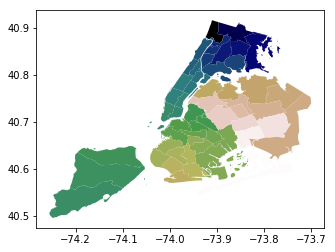

In [7]:
sbas = gpd.read_file('../data/Public Use Microdata Areas (PUMA)/')
sbas['puma'] = sbas['puma'].astype('int64')
sbas.plot(cmap='gist_earth')
plt.show()

In [8]:
sbas = sbas.merge(puma_cd_name, on='puma')

In [9]:
puma_cd = pd.read_csv('../data/PUMA_CD_NAME.csv')
puma_cd['cd'] = puma_cd['cd'].str.replace(" ", "")
sbas['cd'] = sbas['cd'].str.replace(" ","")

In [10]:
G = nx.Graph()
G.add_nodes_from(sbas.index)
n = len(sbas.index)
for i,row in sbas.iterrows():
    for j in range(i+1,n):
        if row['geometry'].touches(sbas.loc[j]['geometry']):
            dist = row['geometry'].centroid.distance(sbas.loc[j]['geometry'].centroid) 
            G.add_edge(i,j, weight=dist)

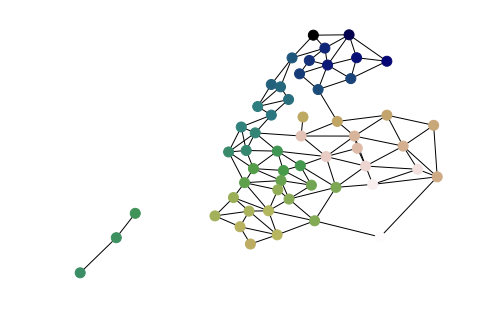

In [11]:
nx.draw(G, pos = sbas['geometry'].centroid.map(lambda p: (p.x,p.y)).to_dict(), node_size=100, node_color=range(n), cmap=plt.cm.gist_earth)
plt.show()

In [12]:
years = ['2000'] + [str(y) for y in range(2005,2017)]
columns = ['cd'] + years
# neighbor_mean = np.zeros(len(sbas.index), len(years))
# moransi = np.zeros(len(sbas.index), len(years))
mean_rents = median_rents.mean()
neighbor_means = pd.DataFrame()
for v in G.nodes():
    puma = sbas.iloc[v]['puma']
    neighbors = G[v].keys()
    neighbor_cds = list(sbas.iloc[neighbors]['cd'])
    rent_rows = median_rents[median_rents['cd'].isin(neighbor_cds)][columns]
    mean_row = rent_rows.mean()
    mean_row['puma'] = puma
    neighbor_means = neighbor_means.append(mean_row, ignore_index=True)

In [13]:
neighbor_means['puma'] = neighbor_means['puma'].astype('int64')
neighbor_means = neighbor_means.merge(puma_cd_name, on = 'puma')
neighbor_means = neighbor_means.set_index('puma')

In [14]:
# wmatrix = pysal.weights.WSP(nx.adj_matrix(G))

In [15]:
subways = pd.read_csv('../data/communitydistrict-residentialunitswithin12mileofasubwaystation.csv')

In [16]:
subways['cd'], subways['CD_Name'] = subways['Community District'].str.split(" - ",1).str
subways['cd'] = subways['cd'].str.replace(" ", "")

In [17]:
# # Merge community district data into PUMAs based on 2010 census
housing_units = pd.read_csv('../data/community_district_housing_units2010.csv')
housing_units['cd'] = housing_units['Community_District'].str.lstrip()
housing_units['cd'] = housing_units['cd'].str.rstrip()
housing_units['Borough'], housing_units['CD_Number'] = housing_units['cd'].str.split(" ",1).str
housing_units['CD_Number']= housing_units['CD_Number'].str.zfill(2)
housing_units['cd'] = housing_units['Borough'] + housing_units['CD_Number']
housing_units = housing_units[['cd', 'Units']]
housing_units['Units'] = housing_units['Units'].str.replace(',','').astype('int64')

In [18]:
population = pd.read_csv('../data/community_district_population2010.csv')
population['cd'] = population['Community_District'].str.lstrip()
population['cd'] = population['cd'].str.rstrip()
population['Borough'], population['CD_Number'] = population['cd'].str.split(" ",1).str
population['CD_Number']= population['CD_Number'].str.zfill(2)
population['cd'] = population['Borough'] + population['CD_Number']
population = population[['cd', 'Population']]

In [19]:
merging = [('BX01', 'BX02'), ('BX03', 'BX06'), ('MN01', 'MN02'), ('MN04', 'MN05')]
subways = subways[['cd', '2016']]
merged = []
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    newval = u *subways[subways['cd']==a]['2016'].values[0] + v * subways[subways['cd']==b]['2016'].values[0]
    newval = newval / float(denom)
    merged.append({
        'cd': a + b, 
        '2016': newval})
subways = subways.append(merged, ignore_index = True)

In [20]:
subways = subways.merge(puma_cd_name, on = 'cd', how = 'outer')

In [21]:
subways = subways.dropna(how='any')

In [22]:
subways = subways.set_index('puma')

In [23]:
new_units = pd.read_csv('../data/communitydistrict-unitsauthorizedbynewresidentialbuildingpermits.csv')
new_units['cd'], new_units['Name'] = new_units['Community District'].str.split(" - ",1).str
new_units['cd'] = new_units['cd'].str.replace(' ','')
years = [str(n) for n in range(2000,2017)]
indices = ['cd', 'Name'] + years
new_units = new_units[indices]
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    row1 = new_units[new_units['cd']==a][years].values
    row2 = new_units[new_units['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    new_units = new_units.append(newrow, ignore_index = True)

In [24]:
new_units = new_units.merge(puma_cd_name, on='cd', how='outer')
new_units = new_units[pd.notnull(new_units['CD_Name'])]
new_units['puma'] = new_units['puma'].astype('int64')
new_units = new_units.set_index('puma')

In [25]:
crime = pd.read_csv('../data/communitydistrict-seriouscrimerateper1000residents.csv')
crime['cd'], crime['CD_Name'] = crime['Community District'].str.split(" - ",1).str
crime['cd'] = crime['cd'].str.replace(' ','')
years = [str(n) for n in range(2006,2017)]
indices = ['cd'] + years
crime = crime[indices]
for i,(a,b) in enumerate(merging):
    u = float(population[population['cd']==a]['Population'].values[0])
    v = float(population[population['cd']==b]['Population'].values[0])
    denom = u + v
    row1 = crime[crime['cd']==a][years].values
    row2 = crime[crime['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    crime = crime.append(newrow, ignore_index = True)

In [26]:
crime = crime.merge(puma_cd_name, on='cd', how='outer')
crime = crime[pd.notnull(crime['CD_Name'])]
crime['puma'] = crime['puma'].astype('int64')
crime = crime.set_index('puma')

In [27]:
years = [str(y) for y in range(2005,2017)]
subways = pd.concat([subways['2016']]*12, axis=1)
subways.columns = years

In [28]:
# horrendous and lazy way to fill in missing values
lineup = crime['2006'].values
crime.insert(0, '2005', lineup)

In [29]:
median_incomes = median_incomes.sort_index()
education_levels = education_levels.sort_index()
percents_white = percents_white.sort_index()
percents_white[years] = percents_white[years].interpolate(method='linear', axis = 0)
subways = subways.sort_index()
new_units[years] = new_units[years].interpolate(method='linear', axis = 0)
new_units = new_units.sort_index()
crime = crime.sort_index()
neighbor_means = neighbor_means.sort_index()
median_rents = median_rents.sort_index()

In [30]:
n = 11 # number of years
m = 7 # number of features
k = 55 # number of PUMAs
# Stack our observations: first axis is PUMA, second is year, third is feature
Xs = np.dstack([median_incomes[years].values, 
                     education_levels[years].values, 
                     percents_white[years].values, 
                     subways[years].values, 
                     new_units[years].values, 
                     crime[years].values, 
                     neighbor_means[years].values, 
                     median_rents[years].ewm(com=2).mean().values])

# Observations
Y = median_rents[years].astype('float32').values
X_test = Xs[:,-1,:]
Y_test = Y[:,-1]
Y = Y[:,:-1]
X = Xs[:, :-1, :]
clf = tree.DecisionTreeRegressor()
predictions = np.zeros(k)
resids = np.zeros(k)
for i in range(k):
    clf = clf.fit(X[i], Y[i])
    predictions[i] = clf.predict(X_test[i,:].reshape(1, -1))

In [31]:
sns.set_style('whitegrid')
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.plot(errs, 'o-')
ax.set_title('Rents Actual vs Predicted')
ax.set_xticks(ind + width / 2)
errs = predictions - Y_test
ax.set_title('Decision Tree Prediction Error')
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
plt.ylabel('Error (Dollars/Month)')
plt.show()

NameError: name 'errs' is not defined

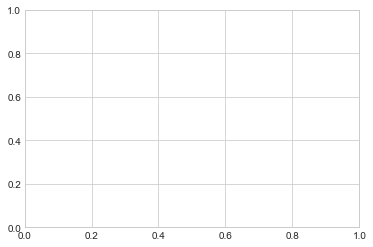

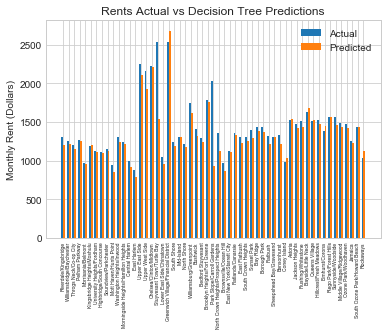

In [32]:
sns.set_style("whitegrid")
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.bar(ind, Y_test, width, bottom=0)
p2 = ax.bar(ind + width, predictions, width, bottom=0)
ax.set_title('Rents Actual vs Decision Tree Predictions')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.legend((p1[0], p2[0]), ('Actual', 'Predicted'))
plt.ylabel("Monthly Rent (Dollars)")
plt.show()

In [33]:
n = 11 # number of years
m = 7 # number of features
k = 55 # number of PUMAs
# Stack our observations: first axis is PUMA, second is year, third is feature
Xs = np.dstack([median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values])
# Xs = np.dstack([median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values, neighbor_means[years].values])
# Xs = np.dstack([median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values, median_rents[years].ewm(com=2).mean().values])
# Xs = np.dstack([median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values, neighbor_means[years].values, median_rents[years].ewm(com=2).mean().values])

# Observations
Y = median_rents[years].astype('float32').values
X_test = Xs[:,-2:,:]
Y_test = Y[:,-2:]
Y = Y[:,:-2]
X = Xs[:, :-2, :]
clf = linear_model.LinearRegression()
predictions = np.zeros((k,2))
rvals = np.zeros(k)
mses = np.zeros(k)
residslin1 = np.zeros(k)
for i in range(k):
    clf = clf.fit(X[i], Y[i])
    predictions[i,:] = clf.predict(X_test[i,:])
    rvals[i] = clf.score(X[i], Y[i])
    mses[i] = mean_squared_error(Y[i], clf.predict(X[i]))
    residslin1[i] = Y_test[i,1] - clf.predict(X_test[i,1].reshape(1, -1))

In [34]:
n = 11 # number of years
m = 7 # number of features
k = 55 # number of PUMAs
# Stack our observations: first axis is PUMA, second is year, third is feature
# Xs = np.dstack([median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values])
# Xs = np.dstack([median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values, neighbor_means[years].values])
# Xs = np.dstack([median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values, median_rents[years].ewm(com=2).mean().values])
Xs = np.dstack([median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values, neighbor_means[years].values, median_rents[years].ewm(com=2).mean().values])

# Observations
Y = median_rents[years].astype('float32').values
X_test = Xs[:,-2:,:]
Y_test = Y[:,-2:]
Y = Y[:,:-2]
X = Xs[:, :-2, :]
clf = linear_model.LinearRegression()
predictions = np.zeros((k,2))
rvals = np.zeros(k)
mses = np.zeros(k)
residslin2 = np.zeros(k)
for i in range(k):
    clf = clf.fit(X[i], Y[i])
    predictions[i,:] = clf.predict(X_test[i,:])
    rvals[i] = clf.score(X[i], Y[i])
    mses[i] = mean_squared_error(Y[i], clf.predict(X[i]))
    residslin2[i] = Y_test[i,1] - clf.predict(X_test[i,1].reshape(1, -1))

In [35]:
# Observations
Y = median_rents[years].astype('float32').values
Y_test = Y[:,-2:]
Y = Y[:,:-2]
X = Xs[:, :-2, :]

predictions = np.zeros((k,2))
rvals = np.zeros(k)
mses = np.zeros(k)
residsexp = np.zeros(k)
for i in range(k-1):
    fit2 = SimpleExpSmoothing(Y[i]).fit(smoothing_level=0.6,optimized=False)
    predictions[i,:] = fit2.forecast(1)
    mses[i] = mean_squared_error(Y_test[i], predictions[i])
    residsexp[i] = Y_test[i,1] - predictions[i,1]

In [36]:
Cs = np.corrcoef(np.append(X[0],Y[0].reshape(10,1), axis=1).T)
for i in range(1,k):
    m = np.corrcoef(np.append(X[0],Y[0].reshape(10,1), axis=1).T)
    Cs=np.dstack([Cs,m])

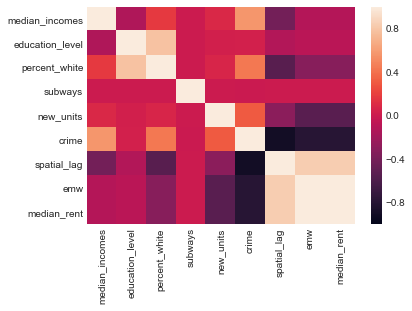

In [37]:
feature_labels = ['median_incomes', 'education_level', 'percent_white', 'subways', 'new_units', 'crime', 'spatial_lag','emw', 'median_rent']

sns.heatmap(Cs.mean(axis=2), xticklabels = feature_labels, yticklabels = feature_labels, vmin = -1, vmax =1)
plt.show()

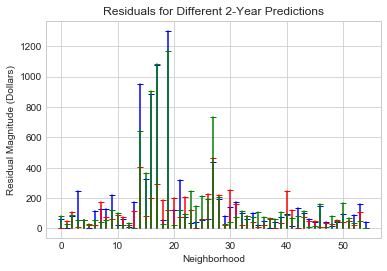

In [36]:
fig, ax = plt.subplots()
ax.stem(range(k),np.abs(residslin1), markerfmt='b_', linefmt='b', basefmt=' ')
ax.stem(range(k),np.abs(residslin2), markerfmt='r_', linefmt='r', basefmt=' ')
ax.stem(range(k),np.abs(residsexp), markerfmt='g_', linefmt='g', basefmt= ' ')
plt.title('Residuals for Different 2-Year Predictions')
plt.xlabel('Neighborhood')
plt.ylabel('Residual Magnitude (Dollars)')
plt.show()

In [37]:
Xs.shape

(55, 12, 8)

In [38]:
n = 10 # number of years
m = 8 # number of features
k = 55 # number of PUMAs
years_ints = np.array(years).astype('int')
test_years = years_ints[0:n]
points_per_year = 12
X_interpolated = si.interpolate.interp1d(test_years,X,axis=1,kind='linear')
Y_interpolated = si.interpolate.interp1d(test_years,Y,axis=1,kind='linear')
ts = np.linspace(test_years[0], test_years[-1],n*points_per_year)

In [39]:
Y_interpolated(ts).shape

(55, 120)

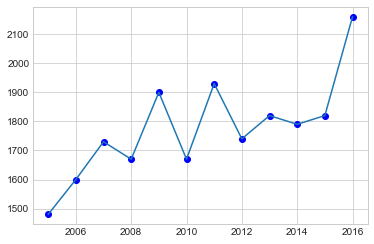

In [195]:
y = median_rents[years].iloc[15].transpose().values
xs = np.array(map(int, years))
ax = plt.plot(yearsnum,y, 'bo')
f = si.interpolate.interp1d(yearsnum,y,kind='linear')
xnew = np.arange(yearsnum[0], yearsnum[-1] + 0.1, 0.1)
ynew = f(xnew)
plt.plot(xnew, ynew)
plt.show()

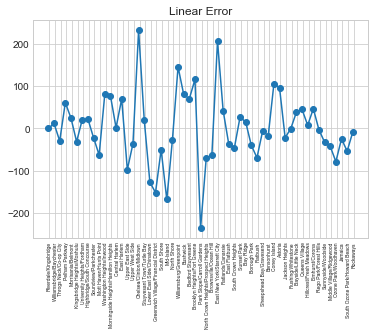

In [61]:
sns.set_style('whitegrid')
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
ax.set_title('Rents Actual vs Predicted')
ax.set_xticks(ind + width / 2)
errs = predictions - Y_test
p1 = ax.plot(errs, 'o-')
ax.set_title('Linear Error')
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.yaxis.set_label("Monthly Rent (Dollars)")
plt.show()

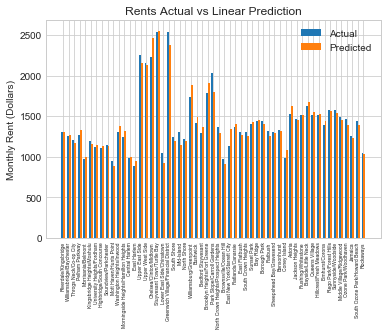

In [62]:
sns.set_style("whitegrid")
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.bar(ind, Y_test, width, bottom=0)
p2 = ax.bar(ind + width, predictions, width, bottom=0)
ax.set_title('Rents Actual vs Linear Prediction')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.legend((p1[0], p2[0]), ('Actual', 'Predicted'))
plt.ylabel("Monthly Rent (Dollars)")
plt.show()

In [54]:
colors = sns.cubehelix_palette(8)
colors

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8822898168737189, 0.695820866705742, 0.7065457119485431],
 [0.8135380254700676, 0.5705055182357822, 0.639280859468155],
 [0.7195800708349119, 0.45537982893127477, 0.5861062995810926],
 [0.6046906802634469, 0.35739308184976665, 0.5337407853692406],
 [0.46496993672552045, 0.26868986121314253, 0.4636527763640647],
 [0.3210194743259347, 0.19303051265196464, 0.3707881677724792],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

In [21]:
row = neighbor_means.loc[3702]
plt.plot(years, row[years], color = colors[5])
plt.xlabel('Year')
plt.ylabel('Rent (Dollars)')
plt.title('Mean Rent of Adjacent Neighborhoods')
plt.show()

NameError: name 'neighbor_means' is not defined

$$x_i = \frac{1}{N_i}\sum_{j \in n(i)} x_j $$

In [22]:
$$\frac{N}{W}\frac{}{}

SyntaxError: invalid syntax (<ipython-input-22-a3695cb7cbd7>, line 1)